# Import

In [38]:
import numpy as np
#from sklearn.model_selection import train_test_split
#import os, sys
from PIL import Image
import matplotlib.pyplot as plt
from collections import Counter

#import tensorflow as tf
#from tensorflow import keras

from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
9
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping, ReduceLROnPlateau

from get_dataset import get_training_and_validation

from tensorflow.keras.models import save_model, load_model

# Load Data

In [39]:
batch_size = 16
epochs = 50
IMG_HEIGHT = 256
IMG_WIDTH = 256

# make sure to write own classifier-function in next cell
# if num_classes is greater than 2



In [46]:
# this filter allows all combination with exactly 1 human on it
# artificial masks (photoshop, cg), are not distinguished

# this implicite sets the ['class'] as follows:
#   with_mask >= 1 -> 'mask'
#   with_mask == 0 -> 'no_mask'
#  classifier-attribute can be set to own function for matching data-rows into classes
frame = get_training_and_validation(people_per_img = 1, with_mask=None, no_mask=None, unknown=0,validation_split=0.15 ,test_split=0.1)

train_frame=frame[0]
val_frame=frame[1]
test_frame=frame[2]


print('Filter returned {:d} train images'.format(len(train_frame)))
print(Counter(train_frame['class']))
print('Filter returned {:d} valid images'.format(len(val_frame)))
try:
    print('Filter returned {:d} test images'.format(len(test_frame)))
except:
    print ("Filter returned no test images")
    
num_classes = len(Counter(train_frame['class']))

Filter returned 1766 train images
Counter({'no_mask': 954, 'mask': 812})
Filter returned 352 valid images
Filter returned 235 test images


# Data preparation

In [47]:
def get_data_generator(image_generator, frame, shuffle=True):
    return image_generator.flow_from_dataframe(frame, directory='./', x_col='Path', y_col='class', color_mode="rgb",
                                                 batch_size = batch_size, shuffle=shuffle, target_size=(IMG_HEIGHT, IMG_WIDTH), class_mode='categorical')

In [48]:
# generator for all data
image_generator = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=15,
                    width_shift_range=.15,
                    height_shift_range=.15,
                    horizontal_flip=True,
                    zoom_range=0.2
                    )
image_generator_test = ImageDataGenerator(rescale=1./255)

In [49]:
train_data_gen = get_data_generator(image_generator, train_frame)

validation_data_gen = get_data_generator(image_generator_test, val_frame)


Found 1757 validated image filenames belonging to 2 classes.
Found 351 validated image filenames belonging to 2 classes.


C:\Users\Daniel\.conda\envs\tf\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:273: UserWarning: Found 1 invalid image filename(s) in x_col="Path". These filename(s) will be ignored.
  .format(n_invalid, x_col)


In [50]:
sample_training_images, _ = next(train_data_gen)

In [51]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img,interpolation='none')
        ax.axis('off')
    plt.tight_layout()
    plt.show()

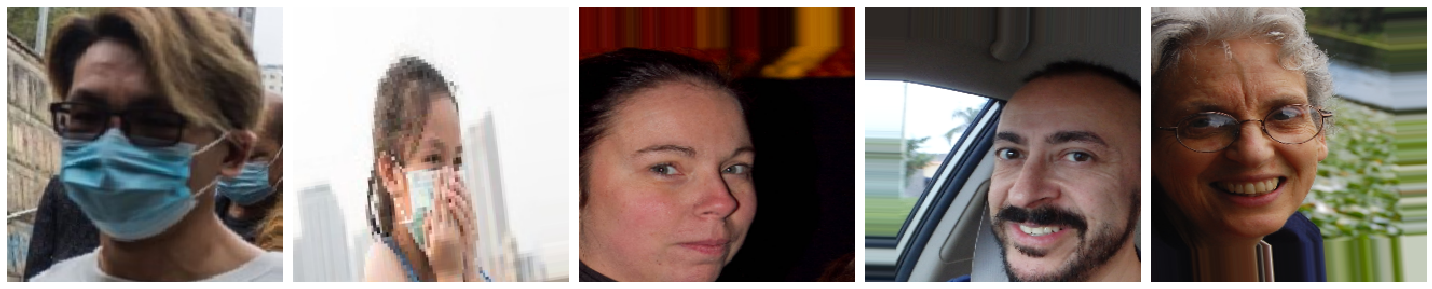

In [52]:
plotImages(sample_training_images[:5])

# Create the model

In [10]:
model = Sequential([
    Conv2D(32, 3, padding='same', strides=2,activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', strides=2,activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', strides=2,activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(num_classes, activation='softmax')
])

In [11]:
#resnet_weights_path = '../input/resnet50/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'
#model = Sequential()
#model.add(ResNet50(include_top=False, pooling='avg', weights='imagenet'))
##model.add(Dense(num_classes, activation='softmax'))
#model.add(Dense(512, activation='relu'))
#model.add(Dense(1))
#model.layers[0].trainable = False

In [12]:
model.compile(optimizer='adam',
              loss=BinaryCrossentropy(from_logits=True),
              metrics=['accuracy']) #TODO: maype 'acc' instead of 'accuracy'

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 64)          36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 2, 2, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 256)               0

# Train the model

In [14]:
epochs_saved=epochs
epochs=5
history = model.fit_generator(
    train_data_gen,
    steps_per_epoch = len(train_data_gen),
    epochs=epochs,
    validation_data=validation_data_gen,
    validation_steps =len(validation_data_gen)
)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 110 steps, validate for 22 steps
Epoch 1/5
110/110 [==============================] - 29s 264ms/step - loss: 0.6705 - accuracy: 0.6526 - val_loss: 0.5819 - val_accuracy: 0.8490
Epoch 2/5
110/110 [==============================] - 28s 254ms/step - loss: 0.5903 - accuracy: 0.8280 - val_loss: 0.5760 - val_accuracy: 0.8575
Epoch 3/5
110/110 [==============================] - 27s 250ms/step - loss: 0.5878 - accuracy: 0.8331 - val_loss: 0.5786 - val_accuracy: 0.8490
Epoch 4/5
110/110 [==============================] - 28s 254ms/step - loss: 0.5928 - accuracy: 0.8206 - val_loss: 0.5622 - val_accuracy: 0.8718
Epoch 5/5
110/110 [==============================] - 28s 253ms/step - loss: 0.5769 - accuracy: 0.8508 - val_loss: 0.5714 - val_accuracy: 0.8661


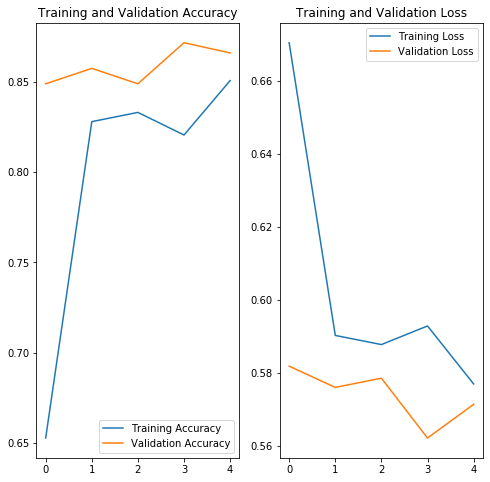

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [16]:
#RESTORE
epochs=epochs_saved

# Data augmentation

## Flip and Shift

In [17]:
image_gen = ImageDataGenerator(rescale=1./255, horizontal_flip=True,width_shift_range=.15,
                    height_shift_range=.15,)

train_data_gen = get_data_generator(image_gen, train_frame)

Found 1756 validated image filenames belonging to 2 classes.


C:\Users\Daniel\.conda\envs\tf\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:273: UserWarning: Found 10 invalid image filename(s) in x_col="Path". These filename(s) will be ignored.
  .format(n_invalid, x_col)


In [18]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]

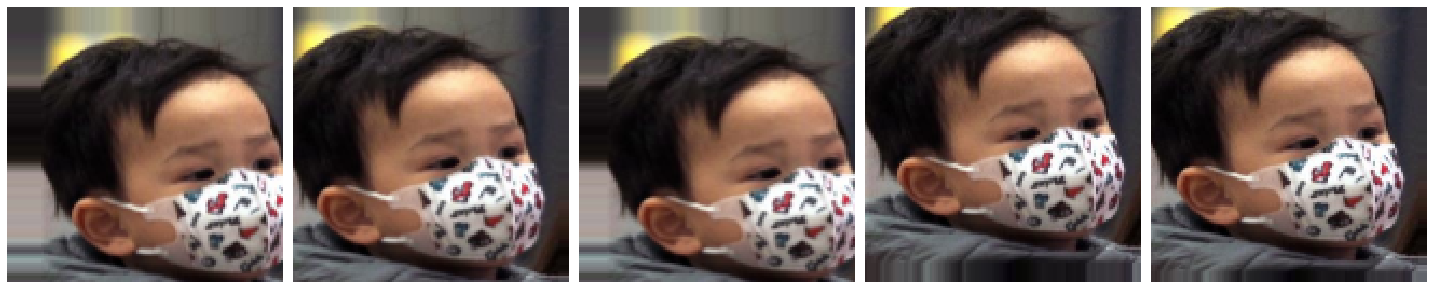

In [19]:
# Re-use the same custom plotting function defined and used
# above to visualize the training images
plotImages(augmented_images)

## Rotate

In [20]:
image_gen = ImageDataGenerator(rescale=1./255, rotation_range=15)

train_data_gen = get_data_generator(image_gen, train_frame)

Found 1756 validated image filenames belonging to 2 classes.


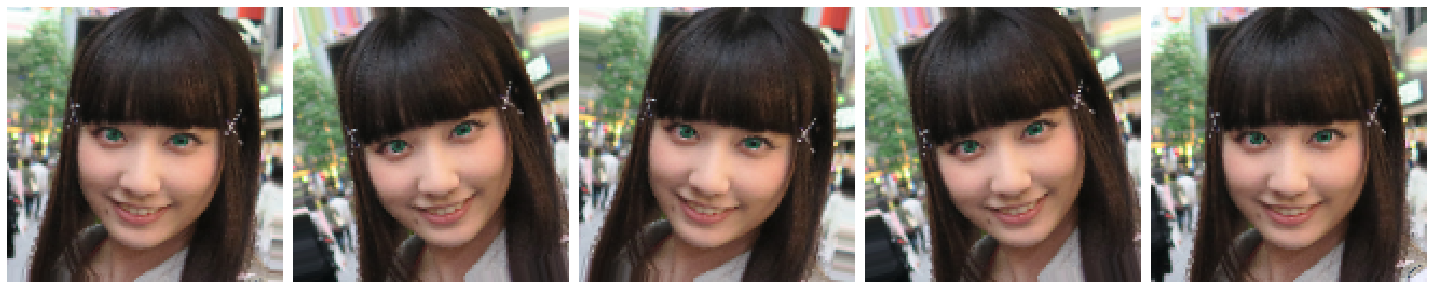

In [21]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]

plotImages(augmented_images)

## Zoom

In [22]:
# zoom_range from 0 - 1 where 1 = 100%.
image_gen = ImageDataGenerator(rescale=1./255, zoom_range=0.5) # 

In [23]:
train_data_gen = get_data_generator(image_gen, train_frame)

augmented_images = [train_data_gen[0][0][0] for i in range(5)]

Found 1756 validated image filenames belonging to 2 classes.


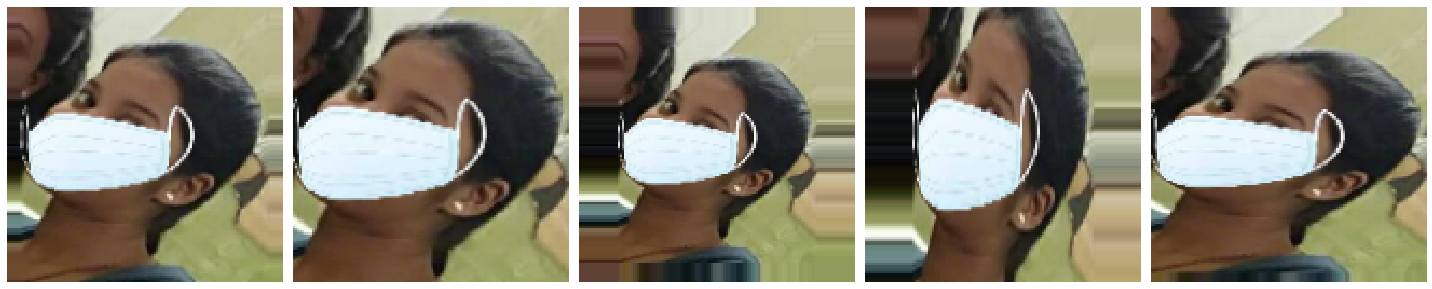

In [24]:
plotImages(augmented_images)

## Together

In [53]:
train_data_gen = get_data_generator(image_generator, train_frame)

validation_data_gen = get_data_generator(image_generator_test, val_frame)

Found 1757 validated image filenames belonging to 2 classes.
Found 351 validated image filenames belonging to 2 classes.


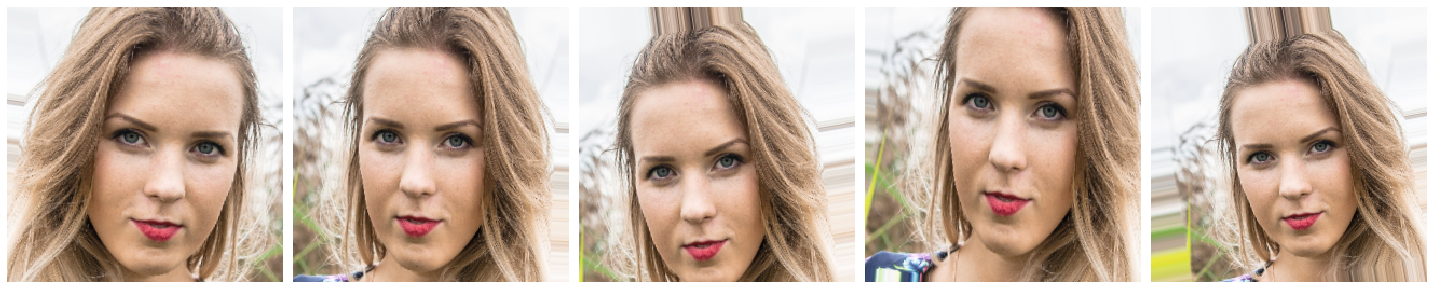

In [54]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

# Model 2 with Dropout

In [55]:
model_new = Sequential([
    Conv2D(32, 3, padding='same', activation='relu', 
           input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', strides=2, activation='relu'),
    MaxPooling2D(),
    Dropout(0.2),
    Conv2D(128, 3, padding='same', strides=2, activation='relu'),
    MaxPooling2D(),
    Dropout(0.2),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])


In [56]:
model_new.compile( optimizer='rmsprop',
                  loss='binary_crossentropy',#tf.keras.losses.BinaryCrossentropy(from_logits=True),
                  metrics=['accuracy'])

model_new.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 256, 256, 32)      896       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 16, 16, 128)       73856     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 8, 8, 128)        

# Train2

In [57]:
checkpoint_filepath = './tmp/model_checkpoint'

model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

earlyStopping = EarlyStopping(monitor='val_loss', patience=15, verbose=1, mode='min')

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, verbose=1,
                              cooldown=2, mode='auto',min_delta=0.0001, min_lr=0)

In [58]:
#model_new.fit_generator?

In [59]:
history = model_new.fit(
    train_data_gen,
    #steps_per_epoch=len(train_data_gen),
    epochs=epochs,
    validation_data=validation_data_gen,
    #validation_steps=len(validation_data_gen),
    callbacks=[model_checkpoint_callback,earlyStopping,reduce_lr]
)
#model_new.load_weights(checkpoint_filepath)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 110 steps, validate for 22 steps
Epoch 1/50
110/110 [==============================] - 63s 577ms/step - loss: 0.5974 - accuracy: 0.7154 - val_loss: 0.5006 - val_accuracy: 0.8262
Epoch 2/50
110/110 [==============================] - 61s 551ms/step - loss: 0.4592 - accuracy: 0.7928 - val_loss: 0.2873 - val_accuracy: 0.8661
Epoch 3/50
110/110 [==============================] - 60s 548ms/step - loss: 0.4181 - accuracy: 0.8127 - val_loss: 0.2562 - val_accuracy: 0.8661
Epoch 4/50
110/110 [==============================] - 61s 555ms/step - loss: 0.3778 - accuracy: 0.8367 - val_loss: 0.2197 - val_accuracy: 0.9060
Epoch 5/50
110/110 [==============================] - 61s 555ms/step - loss: 0.3295 - accuracy: 0.8725 - val_loss: 0.2522 - val_accuracy: 0.8832
Epoch 6/50
110/110 [==============================] - 57s 516ms/step - loss: 0.3310 - accuracy: 0.8583 - val_loss: 0.2979 - val_accuracy: 0.8661
Epoch 7/50
110/110 [=================

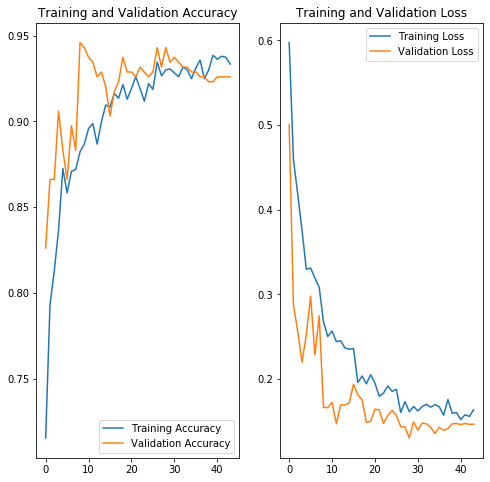

In [60]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Test

In [61]:
test_data_gen = get_data_generator(image_generator_test, test_frame, shuffle=False)

Found 232 validated image filenames belonging to 2 classes.


C:\Users\Daniel\.conda\envs\tf\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:273: UserWarning: Found 3 invalid image filename(s) in x_col="Path". These filename(s) will be ignored.
  .format(n_invalid, x_col)


In [62]:
#predict=model.predict(test_data_gen)
#predict

In [63]:
from sklearn.metrics import classification_report, confusion_matrix
model_new.load_weights(checkpoint_filepath)
used_model=model_new

total_test=len(test_frame)

Y_pred = used_model.predict(test_data_gen)#, steps=total_test // batch_size+1)
predict_class = np.argmax(Y_pred, axis=1)
predict_class = predict_class.tolist()

ausgabe=0
if ausgabe:
    print('Predict\n',predict_class)
    print('Klassen\n',test_data_gen.classes)
    classes_table=[int(i=='no_mask') for i in test_frame['class'].tolist()]
    print('Klassen Tabelle\n', classes_table)
    print(test_frame['class'].tolist())


print('Confusion Matrix')
print(confusion_matrix(test_data_gen.classes, predict_class))
print('Classification Report')
target_names = ['Mask','NoMask']
print(classification_report(test_data_gen.classes, predict_class, target_names=target_names))

Confusion Matrix
[[103  13]
 [  6 110]]
Classification Report
              precision    recall  f1-score   support

        Mask       0.94      0.89      0.92       116
      NoMask       0.89      0.95      0.92       116

    accuracy                           0.92       232
   macro avg       0.92      0.92      0.92       232
weighted avg       0.92      0.92      0.92       232



In [64]:
from tensorflow.keras.models import save_model, load_model
#used_model.save('saved_model')
#used_model.save('saved_model_test')